# ETL Processes
Use this notebook to develop the ETL process for each of your tables before completing the `etl.py` file to load the whole datasets.

In [1]:
import os
import glob
import psycopg2
import pandas as pd
from IPython.display import Image
from sql_queries import *
from tqdm import tqdm

In [2]:
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

In [3]:
def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))
    
    return all_files

In [4]:
def process_data(cur, conn, filepath, func):
    # get all files matching extension from directory
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))

    # get total number of files found
    num_files = len(all_files)
    print('{} files found in {}'.format(num_files, filepath))

    with tqdm(total=num_files) as pbar:
        for i, datafile in enumerate(all_files, 1):
            func(cur, datafile)
            conn.commit()
            pbar.update(1)
#             print('{}/{} files processed.'.format(i, num_files))


---
---
# Process `song_data`
In this first part, you'll perform ETL on the first dataset, `song_data`, to create the `songs` and `artists` dimensional tables.

Let's perform ETL on a single song file and load a single record into each table to start.
- Use the `get_files` function provided above to get a list of all song JSON files in `data/song_data`
- Select the first song in this list
- Read the song file and view the data

In [5]:
song_files = get_files('data/song_data')

In [6]:
print('{} records'.format(len(song_files)))

71 records


In [7]:
filepath = song_files[0]

In [8]:
filepath

'/home/workspace/data/song_data/A/A/C/TRAACER128F4290F96.json'

In [9]:
df = pd.read_json(filepath, lines=True)
df.head()

artist_id  artist_latitude    artist_location  artist_longitude  \
0  ARMAC4T1187FB3FA4C         40.82624  Morris Plains, NJ         -74.47995   

                 artist_name   duration  num_songs             song_id  \
0  The Dillinger Escape Plan  207.77751          1  SOBBUGU12A8C13E95D   

                             title  year  
0  Setting Fire to Sleeping Giants  2004

---
## #1: `songs` Table

#### 1.1 &mdash; Extract Data for Songs Table
- Select columns for song ID, title, artist ID, year, and duration
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `song_data`

In [10]:
df.values.tolist()

[['ARMAC4T1187FB3FA4C',
  40.82624,
  'Morris Plains, NJ',
  -74.47995,
  'The Dillinger Escape Plan',
  207.77751,
  1,
  'SOBBUGU12A8C13E95D',
  'Setting Fire to Sleeping Giants',
  2004]]

In [11]:
song_df = df[['song_id', 'title', 'artist_id', 'year', 'duration']]
first_song_record = song_df.values[0].tolist()

assert isinstance(first_song_record, list), 'first_song_record should be a list'
first_song_record

['SOBBUGU12A8C13E95D',
 'Setting Fire to Sleeping Giants',
 'ARMAC4T1187FB3FA4C',
 2004,
 207.77751]

In [12]:
# verify that record matches dataframe

song_df

song_id                            title           artist_id  \
0  SOBBUGU12A8C13E95D  Setting Fire to Sleeping Giants  ARMAC4T1187FB3FA4C   

   year   duration  
0  2004  207.77751

#### 1.2 &mdash; Insert a single song record into Song Table
Implement the `song_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song into the `songs` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songs` table in the sparkify database.

In [13]:
# preview query (to verify column order)

song_table_insert

'\n    INSERT INTO songs (song_id, title, artist_id, year, duration)\n    VALUES (%s, %s, %s, %s, %s)\n    ON CONFLICT (song_id) \n    DO UPDATE \n    SET title=EXCLUDED.title, artist_id=EXCLUDED.artist_id, year=EXCLUDED.year, duration=EXCLUDED.duration\n'

In [14]:
# insert first song record

cur.execute(song_table_insert, first_song_record)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

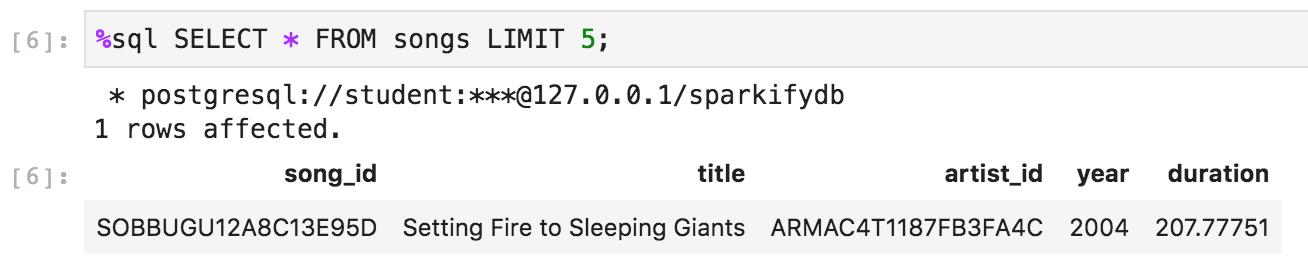

In [15]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_song_insert_confirmation.png', width=650)

#### 1.3 &mdash; Insert all song records into Song Table

In [16]:
# incorporate steps above into a song processing function

def process_song_file(cur, filepath):
    # create dataframe
    df = pd.read_json(filepath, lines=True)
    
    # extract song values
    song_record = df[['song_id', 'title', 'artist_id', 'year', 'duration']].values[0].tolist()
    
    # insert song record
    cur.execute(song_table_insert, song_record)
    conn.commit()


In [17]:
# insert all song records

process_data(cur, conn, filepath='data/song_data', func=process_song_file)

 10%|▉         | 7/71 [00:00<00:01, 63.27it/s]

71 files found in data/song_data


100%|██████████| 71/71 [00:00<00:00, 83.89it/s]


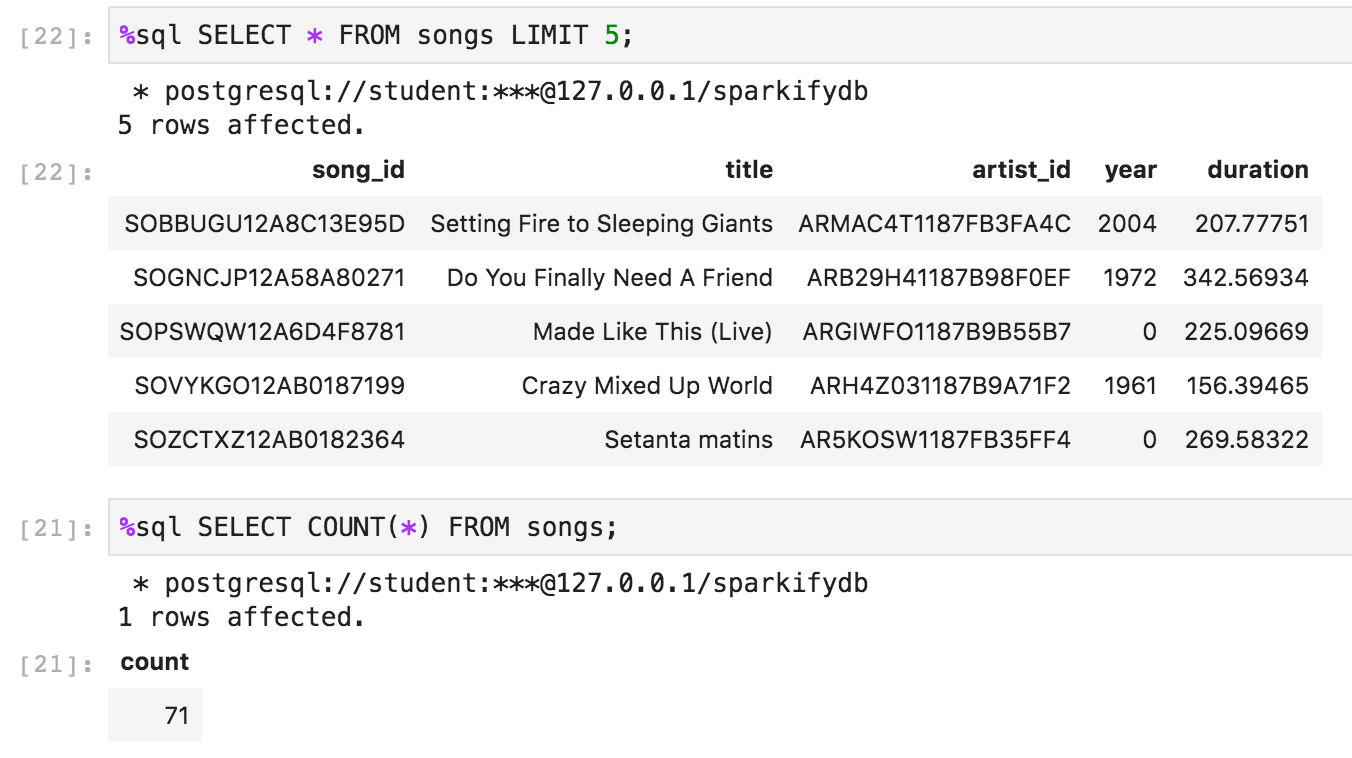

In [18]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_songs_insert_all_confirmation.png', width=650)

---
## #2: `artists` Table

#### 2.1 &mdash; Extract Data for Artists Table
- Select columns for artist ID, name, location, latitude, and longitude
- Use `df.values` to select just the values from the dataframe
- Index to select the first (only) record in the dataframe
- Convert the array to a list and set it to `artist_data`

In [19]:
artist_df = df[['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude']]
artist_record = artist_df.values[0].tolist()

# display results
artist_df.head()

artist_id                artist_name    artist_location  \
0  ARMAC4T1187FB3FA4C  The Dillinger Escape Plan  Morris Plains, NJ   

   artist_latitude  artist_longitude  
0         40.82624         -74.47995

In [20]:
artist_record

['ARMAC4T1187FB3FA4C',
 'The Dillinger Escape Plan',
 'Morris Plains, NJ',
 40.82624,
 -74.47995]

#### 2.2 &mdash; Insert a single record into Artist Table
Implement the `artist_table_insert` query in `sql_queries.py` and run the cell below to insert a record for this song's artist into the `artists` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `artists` table in the sparkify database.

In [21]:
# preview query (to verify column order)
artist_table_insert

'\n    INSERT INTO artists (artist_id, name, location, latitude, longitude)\n    VALUES (%s, %s, %s, %s, %s)\n    ON CONFLICT (artist_id) \n    DO UPDATE \n    SET name=EXCLUDED.name, location=EXCLUDED.location, latitude=EXCLUDED.latitude, longitude=EXCLUDED.longitude \n'

In [22]:
cur.execute(artist_table_insert, artist_record)
conn.commit()

Run `test.ipynb` to see if you've successfully added a record to this table.

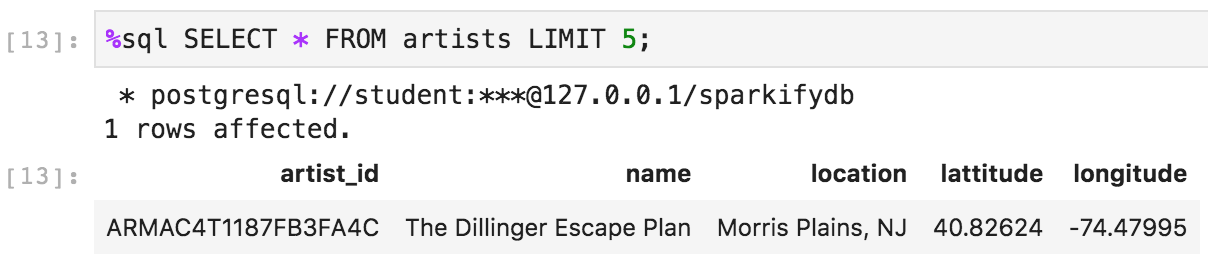

In [23]:
# verify via test.ipynb and display output

Image(filename='images/etl_artist_insert_confirmation.png', width=600)

#### 2.3 &mdash; Insert all artist records into Artist Table


In [24]:
# incorporate steps above into an artist processing function

def process_artist_file(cur, filepath):
    # create dataframe
    df = pd.read_json(filepath, lines=True)
    
    # extract song values
    artist_record = df[['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude']].values[0].tolist()
    
    # insert first song record
    cur.execute(artist_table_insert, artist_record)
    conn.commit()


In [25]:
# insert all song records

process_data(cur, conn, filepath='data/song_data', func=process_artist_file)

  8%|▊         | 6/71 [00:00<00:01, 54.67it/s]

71 files found in data/song_data


100%|██████████| 71/71 [00:00<00:00, 75.64it/s]


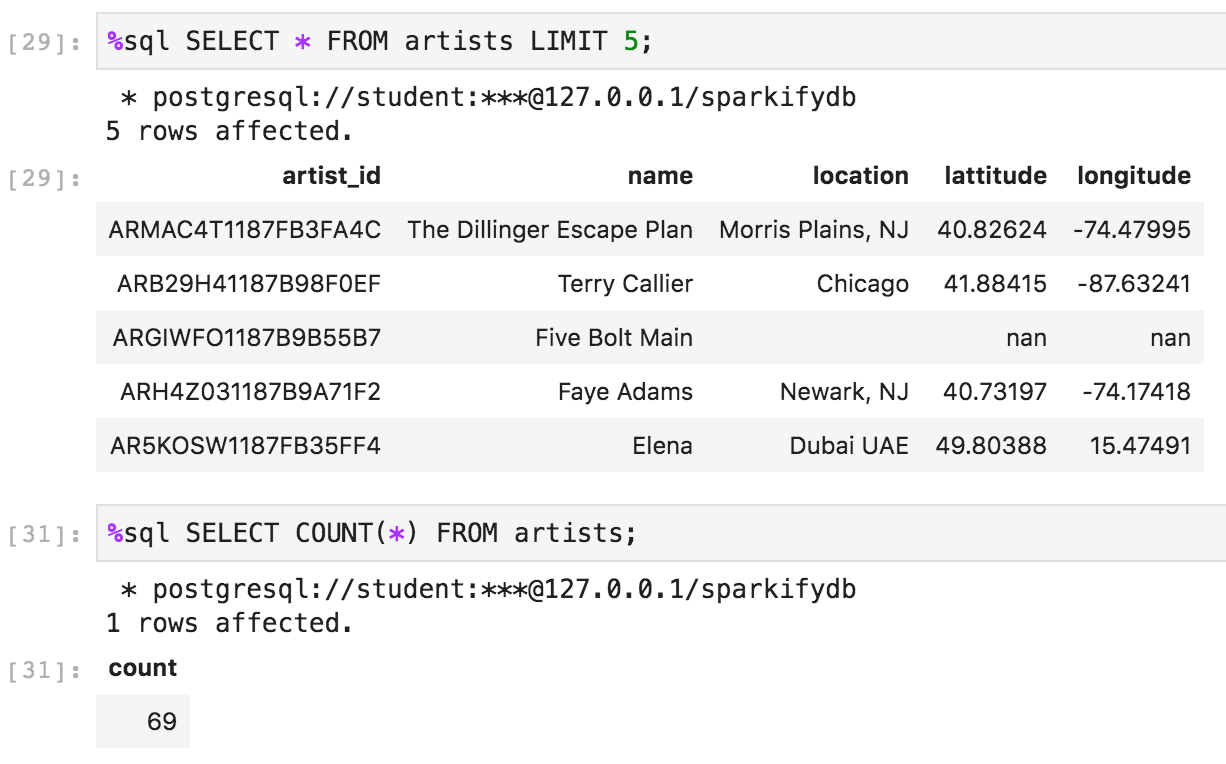

In [26]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_artists_insert_all_confirmation.png', width=600)

---
---
# Process `log_data`
In this part, you'll perform ETL on the second dataset, `log_data`, to create the `time` and `users` dimensional tables, as well as the `songplays` fact table.

Let's perform ETL on a single log file and load a single record into each table.
- Use the `get_files` function provided above to get a list of all log JSON files in `data/log_data`
- Select the first log file in this list
- Read the log file and view the data

In [27]:
log_files = get_files('data/log_data')
print('{} records'.format(len(log_files)))

30 records


In [28]:
for i, filepath in enumerate(log_files):
    print(i, filepath)

0 /home/workspace/data/log_data/2018/11/2018-11-12-events.json
1 /home/workspace/data/log_data/2018/11/2018-11-18-events.json
2 /home/workspace/data/log_data/2018/11/2018-11-04-events.json
3 /home/workspace/data/log_data/2018/11/2018-11-11-events.json
4 /home/workspace/data/log_data/2018/11/2018-11-27-events.json
5 /home/workspace/data/log_data/2018/11/2018-11-29-events.json
6 /home/workspace/data/log_data/2018/11/2018-11-05-events.json
7 /home/workspace/data/log_data/2018/11/2018-11-15-events.json
8 /home/workspace/data/log_data/2018/11/2018-11-23-events.json
9 /home/workspace/data/log_data/2018/11/2018-11-14-events.json
10 /home/workspace/data/log_data/2018/11/2018-11-13-events.json
11 /home/workspace/data/log_data/2018/11/2018-11-06-events.json
12 /home/workspace/data/log_data/2018/11/2018-11-08-events.json
13 /home/workspace/data/log_data/2018/11/2018-11-20-events.json
14 /home/workspace/data/log_data/2018/11/2018-11-02-events.json
15 /home/workspace/data/log_data/2018/11/2018-11-0

#### **NOTE:**
The instructions above say to "select the first log file in this list," but this causes problems when you try to test the `songplays` insertion process later in this notebook. **To avoid this issue, make sure you use this filepath:**
- /home/workspace/data/log_data/2018/11/2018-11-25-events.json

Based on the ordering above, this is `log_files[24]` not `log_files[0]`.

However, in the steps below I continue forward with the first log file (`log_files[0] => 2018-11-12-events.json`) to demonstrate the issue and how I resolved it.

In [29]:
filepath = log_files[0]

In [30]:
print(filepath)

/home/workspace/data/log_data/2018/11/2018-11-12-events.json


In [31]:
log_df = pd.read_json(filepath, lines=True)
print('{} records'.format(len(log_df)))
log_df.head()

213 records


artist       auth   firstName  \
0                                               None  Logged In     Celeste   
1                                           Pavement  Logged In      Sylvie   
2  Barry Tuckwell/Academy of St Martin-in-the-Fie...  Logged In     Celeste   
3                                         Gary Allan  Logged In     Celeste   
4                                               None  Logged In  Jacqueline   

  gender  itemInSession  lastName     length level  \
0      F              0  Williams        NaN  free   
1      F              0      Cruz   99.16036  free   
2      F              1  Williams  277.15873  free   
3      F              2  Williams  211.22567  free   
4      F              0     Lynch        NaN  paid   

                                       location method      page  \
0                             Klamath Falls, OR    GET      Home   
1  Washington-Arlington-Alexandria, DC-VA-MD-WV    PUT  NextSong   
2                             Klamath Falls, OR    PUT  NextSong   
3                             Klamath Falls, OR    PUT  NextSong   
4             Atlanta-Sandy Springs-Roswell, GA    GET      Home   

   registration  sessionId                                               song  \
0  1.541078e+12        438                                               None   
1  1.540266e+12        345                               Mercy:The Laundromat   
2  1.541078e+12        438  Horn Concerto No. 4 in E flat K495: II. Romanc...   
3  1.541078e+12        438                           Nothing On But The Radio   
4  1.540224e+12        389                                               None   

   status             ts                                          userAgent  \
0     200  1541990217796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
1     200  1541990258796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   
2     200  1541990264796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
3     200  1541990541796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
4     200  1541990714796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   

  userId  
0     53  
1     10  
2     53  
3     53  
4     29

---
## #3: `time` Table
### Extract Data for Time Table
1. Filter records by `NextSong` action
1. Convert the `ts` timestamp column to datetime
  - Hint: the current timestamp is in milliseconds
1. Extract the timestamp, hour, day, week of year, month, year, and weekday from the `ts` column and set `time_data` to a list containing these values in order
  - Hint: use pandas' [`dt` attribute](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.html) to access easily datetimelike properties.
1. Specify labels for these columns and set to `column_labels`
1. Create a dataframe, `time_df,` containing the time data for this file by combining `column_labels` and `time_data` into a dictionary and converting this into a dataframe

#### 3.1 &mdash; Filter records by NextSong action

In [32]:
# count records for page!=NextSong for later verification
not_next_song_df = log_df.loc[log_df['page'] != "NextSong"]

# preview results
print('{} records'.format(len(not_next_song_df)))
not_next_song_df.head()

47 records


artist       auth   firstName gender  itemInSession  lastName  length  \
0    None  Logged In     Celeste      F              0  Williams     NaN   
4    None  Logged In  Jacqueline      F              0     Lynch     NaN   
13   None  Logged In      Kimber      F              0    Norris     NaN   
14   None  Logged In        Lily      F              0     Burns     NaN   
15   None  Logged In        Lily      F              1     Burns     NaN   

   level                               location method   page  registration  \
0   free                      Klamath Falls, OR    GET   Home  1.541078e+12   
4   paid      Atlanta-Sandy Springs-Roswell, GA    GET   Home  1.540224e+12   
13  free  New York-Newark-Jersey City, NY-NJ-PA    GET   Home  1.540976e+12   
14  free  New York-Newark-Jersey City, NY-NJ-PA    GET  About  1.540621e+12   
15  free  New York-Newark-Jersey City, NY-NJ-PA    GET   Home  1.540621e+12   

    sessionId  song  status             ts  \
0         438  None     200  1541990217796   
4         389  None     200  1541990714796   
13        412  None     200  1542000167796   
14        466  None     200  1542001320796   
15        466  None     200  1542001337796   

                                            userAgent userId  
0   "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...     53  
4   "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...     29  
13  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...     47  
14  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...     32  
15  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...     32

In [33]:
# filter by NextSong and verify record count
next_song_df = log_df.loc[log_df['page'] == "NextSong"].reindex()

# preview results
print('{} records'.format(len(next_song_df)))
next_song_df.head()

166 records


artist       auth   firstName  \
1                                           Pavement  Logged In      Sylvie   
2  Barry Tuckwell/Academy of St Martin-in-the-Fie...  Logged In     Celeste   
3                                         Gary Allan  Logged In     Celeste   
5                                 Charttraxx Karaoke  Logged In     Celeste   
6                                     The Libertines  Logged In  Jacqueline   

  gender  itemInSession  lastName     length level  \
1      F              0      Cruz   99.16036  free   
2      F              1  Williams  277.15873  free   
3      F              2  Williams  211.22567  free   
5      F              3  Williams  225.17506  free   
6      F              1     Lynch  179.53914  paid   

                                       location method      page  \
1  Washington-Arlington-Alexandria, DC-VA-MD-WV    PUT  NextSong   
2                             Klamath Falls, OR    PUT  NextSong   
3                             Klamath Falls, OR    PUT  NextSong   
5                             Klamath Falls, OR    PUT  NextSong   
6             Atlanta-Sandy Springs-Roswell, GA    PUT  NextSong   

   registration  sessionId                                               song  \
1  1.540266e+12        345                               Mercy:The Laundromat   
2  1.541078e+12        438  Horn Concerto No. 4 in E flat K495: II. Romanc...   
3  1.541078e+12        438                           Nothing On But The Radio   
5  1.541078e+12        438                                          Fireflies   
6  1.540224e+12        389                                  The Good Old Days   

   status             ts                                          userAgent  \
1     200  1541990258796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   
2     200  1541990264796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
3     200  1541990541796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
5     200  1541990752796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
6     200  1541990842796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   

  userId  
1     10  
2     53  
3     53  
5     53  
6     29

##### Record count verification

#### 3.2 &mdash; Convert the ts timestamp column to datetime

In [34]:
import datetime

t = pd.to_datetime(next_song_df.ts, unit='ms')

# preview results
print('{} records'.format(len(t)))
t.head()

166 records


1   2018-11-12 02:37:38.796
2   2018-11-12 02:37:44.796
3   2018-11-12 02:42:21.796
5   2018-11-12 02:45:52.796
6   2018-11-12 02:47:22.796
Name: ts, dtype: datetime64[ns]

#### 3.3 &mdash; Extract the timestamp, hour, day, week of year, month, year, and weekday from the ts column and set time_data to a list containing these values in order

In [35]:
time_data = [t, t.dt.hour, t.dt.day, t.dt.weekofyear, t.dt.month, t.dt.year, t.dt.day_name()]

In [55]:
# preview slice

[time_data[i].values.tolist()[0] for i in range(len(time_data))]

[1541990258796000000, 2, 12, 46, 11, 2018, 'Monday']

#### 3.4 &mdash; Specify labels for these columns and set to column_labels

In [36]:
column_labels = ['ts', 'hour', 'day', 'week of year', 'month', 'year', 'weekday']

assert isinstance(time_data, list), 'time_data should be a list'
assert isinstance(column_labels, list), 'column_labels should be a list'

#### 3.5 &mdash; Create a dataframe, time_df, containing the time data for this file by combining column_labels and time_data into a dictionary and converting this into a dataframe

In [37]:
dictionary = dict(zip(column_labels, time_data))
time_df = pd.DataFrame.from_dict(dictionary)

# preview results
print('{} records'.format(len(time_df)))
time_df.head()

166 records


ts  hour  day  week of year  month  year weekday
1 2018-11-12 02:37:38.796     2   12            46     11  2018  Monday
2 2018-11-12 02:37:44.796     2   12            46     11  2018  Monday
3 2018-11-12 02:42:21.796     2   12            46     11  2018  Monday
5 2018-11-12 02:45:52.796     2   12            46     11  2018  Monday
6 2018-11-12 02:47:22.796     2   12            46     11  2018  Monday

### Insert Records into Time Table
Implement the `time_table_insert` query in `sql_queries.py` and run the cell below to insert records for the timestamps in this log file into the `time` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `time` table in the sparkify database.

In [38]:
for i, row in time_df.iterrows():
    cur.execute(time_table_insert, list(row))
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

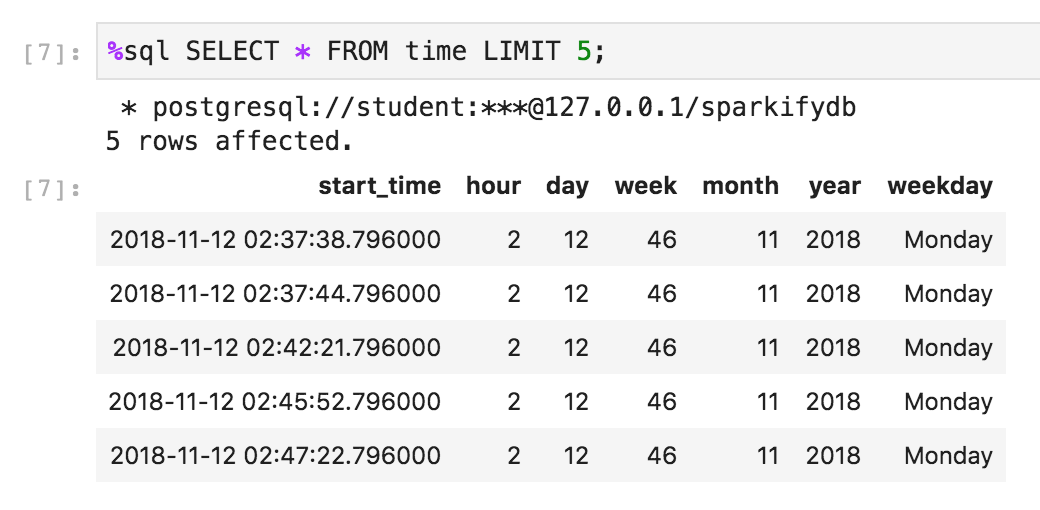

In [39]:
# display output from test.ipynb

Image(filename='images/etl_time_insert_confirmation.png', width=500)

---
## #4: `users` Table
#### Extract Data for Users Table
- Select columns for user ID, first name, last name, gender and level and set to `user_df`

In [40]:
user_df = next_song_df[['userId', 'firstName', 'lastName', 'gender', 'level']]

# preview results
print('{} records'.format(len(user_df)))
user_df.head()

166 records


userId   firstName  lastName gender level
1     10      Sylvie      Cruz      F  free
2     53     Celeste  Williams      F  free
3     53     Celeste  Williams      F  free
5     53     Celeste  Williams      F  free
6     29  Jacqueline     Lynch      F  paid

#### Insert Records into Users Table
Implement the `user_table_insert` query in `sql_queries.py` and run the cell below to insert records for the users in this log file into the `users` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `users` table in the sparkify database.

In [41]:
user_df = user_df.drop_duplicates().sort_values(['userId'])

# preview results
print('{} records'.format(len(user_df)))
user_df

24 records


userId   firstName   lastName gender level
1       10      Sylvie       Cruz      F  free
20     100       Adler    Barrera      M  free
177     12      Austin    Rosales      M  free
155     14    Theodore     Harris      M  free
40      26        Ryan      Smith      M  free
6       29  Jacqueline      Lynch      F  paid
52      32        Lily      Burns      F  free
121     33     Bronson     Harris      M  free
27      34      Evelin      Ayala      F  free
35      37      Jordan      Hicks      F  free
28      49       Chloe     Cuevas      F  free
49      51        Maia      Burke      F  free
2       53     Celeste   Williams      F  free
24      58       Emily     Benson      F  paid
32      61      Samuel   Gonzalez      M  free
36      66       Kevin   Arellano      M  free
12      68      Jordan  Rodriguez      F  free
87      73       Jacob      Klein      M  paid
98      76      Jayden      Duffy      F  free
78      78       Chloe       Roth      F  free
193     80       Tegan     Levine      F  paid
29      86       Aiden       Hess      M  free
18      94        Noah     Chavez      M  free
70      97        Kate    Harrell      F  paid

In [42]:
for i, row in user_df.iterrows():
    cur.execute(user_table_insert, row)
    conn.commit()

Run `test.ipynb` to see if you've successfully added records to this table.

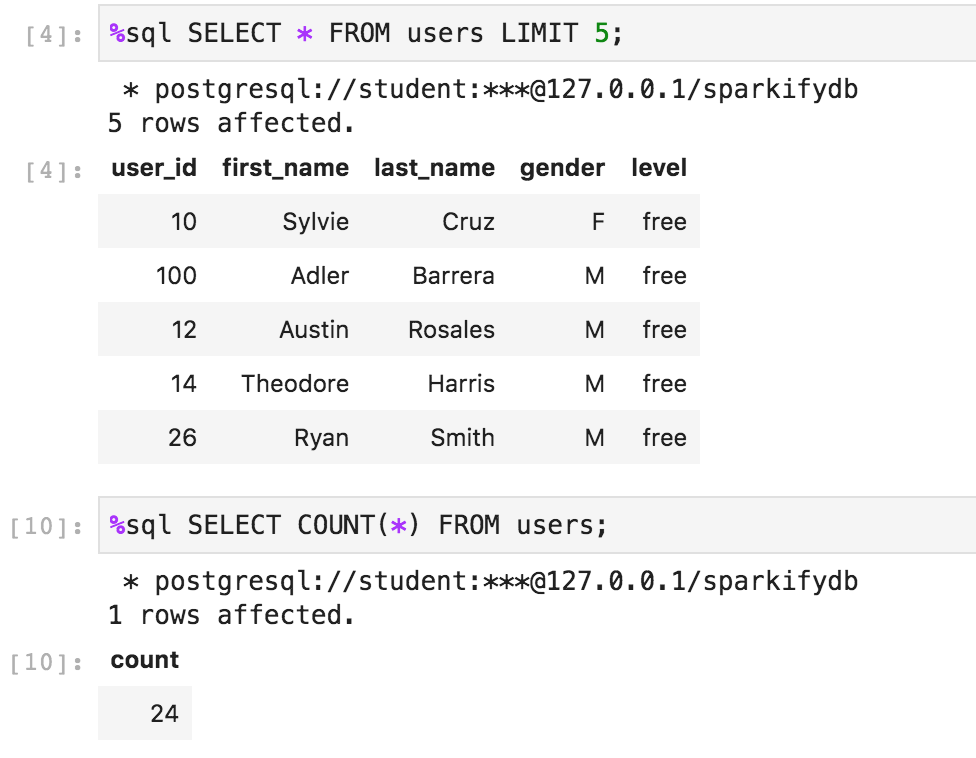

In [43]:
# verify via test.ipynb and display output

Image(filename='images/etl_users_insert_all_confirmation.png', width=500)

## #5: `songplays` Table
#### Extract Data and Songplays Table
This one is a little more complicated since information from the songs table, artists table, and original log file are all needed for the `songplays` table. Since the log file does not specify an ID for either the song or the artist, you'll need to get the song ID and artist ID by querying the songs and artists tables to find matches based on song title, artist name, and song duration time.
- Implement the `song_select` query in `sql_queries.py` to find the song ID and artist ID based on the title, artist name, and duration of a song.
- Select the timestamp, user ID, level, song ID, artist ID, session ID, location, and user agent and set to `songplay_data`

#### Insert Records into Songplays Table
- Implement the `songplay_table_insert` query and run the cell below to insert records for the songplay actions in this log file into the `songplays` table. Remember to run `create_tables.py` before running the cell below to ensure you've created/resetted the `songplays` table in the sparkify database.

In [44]:
log_df.head()

artist       auth   firstName  \
0                                               None  Logged In     Celeste   
1                                           Pavement  Logged In      Sylvie   
2  Barry Tuckwell/Academy of St Martin-in-the-Fie...  Logged In     Celeste   
3                                         Gary Allan  Logged In     Celeste   
4                                               None  Logged In  Jacqueline   

  gender  itemInSession  lastName     length level  \
0      F              0  Williams        NaN  free   
1      F              0      Cruz   99.16036  free   
2      F              1  Williams  277.15873  free   
3      F              2  Williams  211.22567  free   
4      F              0     Lynch        NaN  paid   

                                       location method      page  \
0                             Klamath Falls, OR    GET      Home   
1  Washington-Arlington-Alexandria, DC-VA-MD-WV    PUT  NextSong   
2                             Klamath Falls, OR    PUT  NextSong   
3                             Klamath Falls, OR    PUT  NextSong   
4             Atlanta-Sandy Springs-Roswell, GA    GET      Home   

   registration  sessionId                                               song  \
0  1.541078e+12        438                                               None   
1  1.540266e+12        345                               Mercy:The Laundromat   
2  1.541078e+12        438  Horn Concerto No. 4 in E flat K495: II. Romanc...   
3  1.541078e+12        438                           Nothing On But The Radio   
4  1.540224e+12        389                                               None   

   status             ts                                          userAgent  \
0     200  1541990217796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
1     200  1541990258796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   
2     200  1541990264796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
3     200  1541990541796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
4     200  1541990714796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   

  userId  
0     53  
1     10  
2     53  
3     53  
4     29

In [45]:
next_song_df.head()

artist       auth   firstName  \
1                                           Pavement  Logged In      Sylvie   
2  Barry Tuckwell/Academy of St Martin-in-the-Fie...  Logged In     Celeste   
3                                         Gary Allan  Logged In     Celeste   
5                                 Charttraxx Karaoke  Logged In     Celeste   
6                                     The Libertines  Logged In  Jacqueline   

  gender  itemInSession  lastName     length level  \
1      F              0      Cruz   99.16036  free   
2      F              1  Williams  277.15873  free   
3      F              2  Williams  211.22567  free   
5      F              3  Williams  225.17506  free   
6      F              1     Lynch  179.53914  paid   

                                       location method      page  \
1  Washington-Arlington-Alexandria, DC-VA-MD-WV    PUT  NextSong   
2                             Klamath Falls, OR    PUT  NextSong   
3                             Klamath Falls, OR    PUT  NextSong   
5                             Klamath Falls, OR    PUT  NextSong   
6             Atlanta-Sandy Springs-Roswell, GA    PUT  NextSong   

   registration  sessionId                                               song  \
1  1.540266e+12        345                               Mercy:The Laundromat   
2  1.541078e+12        438  Horn Concerto No. 4 in E flat K495: II. Romanc...   
3  1.541078e+12        438                           Nothing On But The Radio   
5  1.541078e+12        438                                          Fireflies   
6  1.540224e+12        389                                  The Good Old Days   

   status             ts                                          userAgent  \
1     200  1541990258796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   
2     200  1541990264796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
3     200  1541990541796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
5     200  1541990752796  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...   
6     200  1541990842796  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   

  userId  
1     10  
2     53  
3     53  
5     53  
6     29

In [46]:
# display songplay insert statement (to verify columns)
songplay_table_insert

'\n    INSERT INTO songplays (start_time, user_id, level, song_id, artist_id, session_id, location, user_agent)\n    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)\n    ON CONFLICT (songplay_id) \n    DO UPDATE \n    SET start_time=EXCLUDED.start_time, user_id=EXCLUDED.user_id, level=EXCLUDED.level, song_id=EXCLUDED.song_id, artist_id=EXCLUDED.artist_id, session_id=EXCLUDED.session_id, location=EXCLUDED.location, user_agent=EXCLUDED.user_agent\n'

In [47]:
# display song_select query
song_select

'SELECT songs.song_id, artists.artist_id FROM songs \nJOIN artists ON songs.artist_id=artists.artist_id\nWHERE songs.title=%s \nAND artists.name=%s \nAND songs.duration=%s\n'

In [48]:
# counters
log_records_checked = 0
songplay_rows_inserted = 0

for index, row in next_song_df.iterrows():
    # get songid and artistid from song and artist tables
    cur.execute(song_select, (row.song, row.artist, row.length))
    results = cur.fetchone()
    log_records_checked += 1

    if results:
        songid, artistid = results
    else:
        songid, artistid = None, None 

    # insert songplay record if there is a matching song between log file and songs table
    if songid:
        songplay_data = (row.ts, row.userId, row.level, songid, artistid, row.sessionId, row.location, row.userAgent)
        cur.execute(songplay_table_insert, songplay_data)
        conn.commit()
        songplay_rows_inserted += 1
        print('\nsongplay row inserted: \n[{}] {}\n'.format(index, songplay_data))

# verify records checked vs. inserted        
print('\n---------\ntotal log records checked in this file = {}'.format(log_records_checked))
print('total rows inserted = {}'.format(songplay_rows_inserted))


---------
total log records checked in this file = 166
total rows inserted = 0


Run `test.ipynb` to see if you've successfully added records to this table.

#### **ISSUE:**
After much troubleshooting and research, I confirmed that none of the songs in the first log file match any of the songs in the song files (and in turn, the `songs` table). This appears to be an error in the project setup and/or instructions provided by Udacity as recognized [here in the forum](https://knowledge.udacity.com/questions/37605). 

Perhaps one of the other log files contains matching songs. Testing this requires you to loop through all of the log files, which we'll do in the next step when creating `etl.py`.

For now, the cell above shows that zero matching records are found even if you only match on `songs.title` = `row.song`.

In the cell below, I confirm that I'm able to find matching records in `songs.title` when given a valid song title.

In [49]:
for index, row in next_song_df.iterrows():
    # get songid and artistid from song and artist tables
    cur.execute("SELECT * from songs WHERE songs.title='Setting Fire to Sleeping Giants'")
#     cur.execute("SELECT * from songs WHERE songs.title LIKE %s", (row.song,))
#     cur.execute(song_select, (row.song, row.artist, row.length))
    results = cur.fetchone()
    if results:
        print('\nresults = {}'.format(results))
        break


results = ('SOBBUGU12A8C13E95D', 'Setting Fire to Sleeping Giants', 'ARMAC4T1187FB3FA4C', 2004, 207.77751)


#### **UPDATE:**

To correct for the issue above, I added an function to loop over all the log files (see below). Running this shows that there is one matching record located in this log file:

/home/workspace/data/log_data/2018/11/2018-11-25-events.json

For me, the index for this filepath is `log_files[24]` — which is *not* "the first log file in this list" as stated in the notebook instructions.

In [50]:
# incorporate steps above into a songplays processing function

def songplays_insert(cur, filepath):
    '''processes all log files and looks for matching songs in `songs` table'''
    
    # create dataframe
    log_df = pd.read_json(filepath, lines=True)
    
    # filter records where page=NextSong
    next_song_df = log_df.loc[log_df['page'] == "NextSong"].reindex()

    # counter
    log_records_checked = 0

    for index, row in next_song_df.iterrows():
        # get songid and artistid from song and artist tables
        cur.execute(song_select, (row.song, row.artist, row.length))
        results = cur.fetchone()
        log_records_checked += 1

        if results:
            songid, artistid = results
        else:
            songid, artistid = None, None 

        # insert songplay record if there is a matching song between log file and songs table
        rows_inserted = 0
        if songid:
            songplay_data = (row.ts, row.userId, row.level, songid, artistid, row.sessionId, row.location, row.userAgent)
            cur.execute(songplay_table_insert, songplay_data)
            conn.commit()
            rows_inserted += 1
            print('row inserted: {}'.format(songplay_data))

    # verify records checked vs. inserted
    print('\n---------\nfilepath: {}'.format(filepath))
    print('log records checked = {}'.format(log_records_checked))
    print('total rows inserted = {}'.format(rows_inserted))


In [51]:
# insert all log records

process_data(cur, conn, filepath='data/log_data', func=songplays_insert)

  3%|▎         | 1/30 [00:00<00:03,  7.89it/s]

30 files found in data/log_data

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-12-events.json
log records checked = 166
total rows inserted = 0


 10%|█         | 3/30 [00:00<00:03,  8.62it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-18-events.json
log records checked = 138
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-04-events.json
log records checked = 144
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-11-events.json
log records checked = 73
total rows inserted = 0


 20%|██        | 6/30 [00:00<00:03,  7.50it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-27-events.json
log records checked = 256
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-29-events.json
log records checked = 319
total rows inserted = 0


 23%|██▎       | 7/30 [00:00<00:03,  6.45it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-05-events.json
log records checked = 356
total rows inserted = 0


 30%|███       | 9/30 [00:01<00:03,  5.58it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-15-events.json
log records checked = 479
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-23-events.json
log records checked = 239
total rows inserted = 0


 37%|███▋      | 11/30 [00:01<00:03,  5.15it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-14-events.json
log records checked = 390
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-13-events.json
log records checked = 339
total rows inserted = 0


 43%|████▎     | 13/30 [00:01<00:02,  6.80it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-06-events.json
log records checked = 154
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-08-events.json
log records checked = 161
total rows inserted = 0


 47%|████▋     | 14/30 [00:02<00:02,  6.21it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-20-events.json
log records checked = 322
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-02-events.json
log records checked = 155
total rows inserted = 0


 53%|█████▎    | 16/30 [00:02<00:02,  6.95it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-07-events.json
log records checked = 174
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-17-events.json
log records checked = 127
total rows inserted = 0


 63%|██████▎   | 19/30 [00:02<00:01,  6.34it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-28-events.json
log records checked = 363
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-30-events.json
log records checked = 330
total rows inserted = 0


 70%|███████   | 21/30 [00:03<00:01,  6.41it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-24-events.json
log records checked = 314
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-26-events.json
log records checked = 216
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-10-events.json
log records checked = 87
total rows inserted = 0


 80%|████████  | 24/30 [00:03<00:00,  7.21it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-03-events.json
log records checked = 100
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-19-events.json
log records checked = 276
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-25-events.json
log records checked = 41
total rows inserted = 0


 87%|████████▋ | 26/30 [00:03<00:00,  7.09it/s]

row inserted: (1542837407796, '15', 'paid', 'SOZCTXZ12AB0182364', 'AR5KOSW1187FB35FF4', 818, 'Chicago-Naperville-Elgin, IL-IN-WI', '"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/36.0.1985.125 Chrome/36.0.1985.125 Safari/537.36"')

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-21-events.json
log records checked = 437
total rows inserted = 0


 93%|█████████▎| 28/30 [00:04<00:00,  6.45it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-16-events.json
log records checked = 319
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-09-events.json
log records checked = 252
total rows inserted = 0


100%|██████████| 30/30 [00:04<00:00,  7.18it/s]


---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-22-events.json
log records checked = 82
total rows inserted = 0

---------
filepath: /home/workspace/data/log_data/2018/11/2018-11-01-events.json
log records checked = 11
total rows inserted = 0


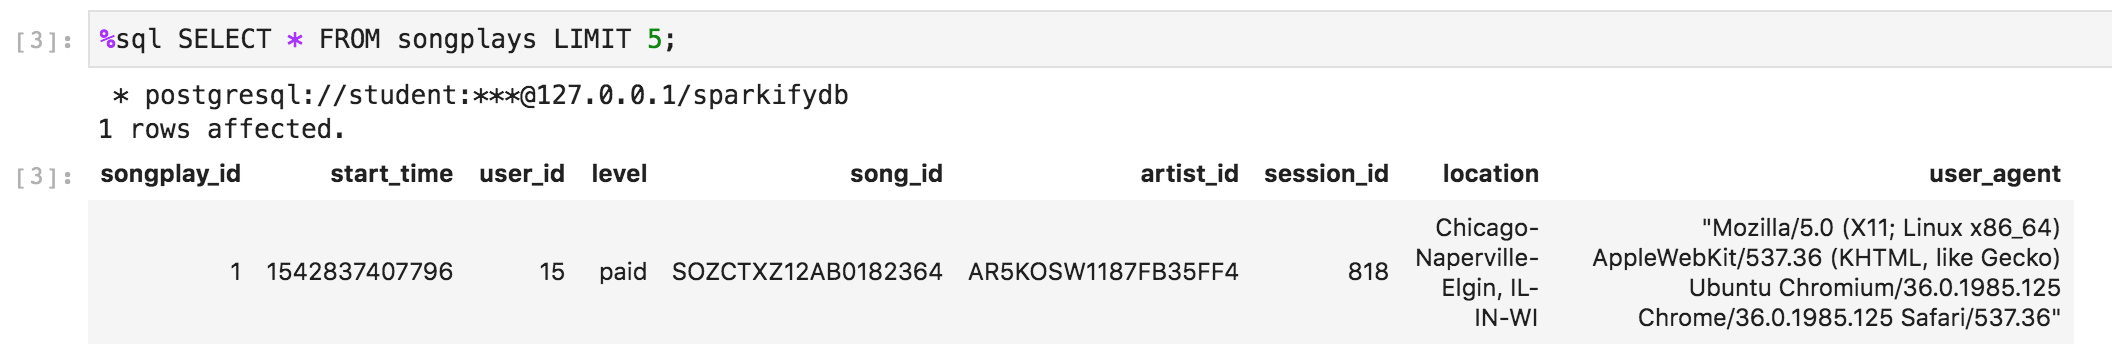

In [52]:
# verify insertion via test.ipynb and display results

Image(filename='images/etl_songplays_insert_confirmation.png', width=950)

# Close Connection to Sparkify Database

In [53]:
conn.close()

# Implement `etl.py`
Use what you've completed in this notebook to implement `etl.py`.